In [1]:
from Utils_16S_Analysis import *

rcParams = {'font.size': 24, 'font.weight': 'normal', 'font.family': 'sans-serif',
            'axes.unicode_minus':False, 'axes.labelweight':'normal'}
plt.rcParams.update(rcParams)

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from copy import deepcopy

In [2]:
filedir = '/Users/harihara/Mount-2/hotspring_metagenome/single_cell_analysis_with_Gabe_Birzu/16S_Read_Alignments/'
samples = listdir(filedir+'Alpha_Alleles/paf_files/')

fdir = '/Users/harihara/Mount-2/hotspring_metagenome/single_cell_analysis_with_Gabe_Birzu/16S_Gene_Segments/'
out = {}
for f in ['Synechococcus_Alpha_16SrRNA','Synechococcus_Beta_16SrRNA','Synechococcus_Gamma_16SrRNA']:
    lines = open(fdir+f+'.fna').readlines()
    s = ''
    for l in lines:
        if not l.startswith('>'):
            s += l.replace("\n","")
    out[f.replace("Synechococcus_","").replace("_16SrRNA","")] = s

In [3]:
df_op = pd.DataFrame()
Samples = {}

for s in samples:
    MisMatches = {}
    
    print(s)
    
    df_alpha = Load_PAF(filedir+'Alpha_Alleles/paf_files/'+s, s)
    df_beta = Load_PAF(filedir+'Beta_Alleles/paf_files/'+s, s)
    df_gamma = Load_PAF(filedir+'Gamma_Alleles/paf_files/'+s, s)
    
    Temp = pd.DataFrame()
    Temp = Temp.append(df_alpha).append(df_beta).append(df_gamma)
    Temp = Temp[Temp['SEnd'] < 1300]
    Temp['Subject'] = Temp['Subject'].str.replace("Synechococcus_","")
    Temp['Subject'] = Temp['Subject'].str.replace("_16SrRNA","")
    Temp['Divergence'] = Temp['MisMatches']/150*100
    
    Mismatches = Temp['MisMatches'].unique()
    for m in Mismatches:
        df_filt = Temp[Temp['MisMatches'] == m]
        CS_strings = df_filt['CS'].tolist()
        SStarts = df_filt['SStart'].tolist()
        SEnds = df_filt['SEnd'].tolist()
        subjects = df_filt['Subject'].tolist()
    
        Alignment_profile = {'Alpha':{'A':np.zeros(1300),'C':np.zeros(1300),
                                          'G':np.zeros(1300),'T':np.zeros(1300)},
                                 'Beta':{'A':np.zeros(1300),'C':np.zeros(1300),
                                         'G':np.zeros(1300),'T':np.zeros(1300)},
                                 'Gamma':{'A':np.zeros(1300),'C':np.zeros(1300),
                                          'G':np.zeros(1300),'T':np.zeros(1300)}}
        
        for i in range(0, len(CS_strings)):
            out_string = Parse_CS_String(CS_strings[i].replace("cs:Z:",""), 
                                         out[subjects[i]][SStarts[i]:SEnds[i]])
            AP = Generate_Alignment_Profile(out_string)
            for n in ['A','C','G','T']:
                Alignment_profile[subjects[i]][n][SStarts[i]:SEnds[i]] += AP[n]
        MisMatches[m] = Alignment_profile
    Samples[s.replace("_FD.paf","")] = MisMatches
    df_op = df_op.append(Temp, ignore_index = True)

HotsprSampleMS50_FD.paf
17571 17768
19536 19747
19979 20191
HotsprottomLayer_2_FD.paf
7149 7267
7335 7450
8467 8611
Hotspr2Sample149_FD.paf
10804 10900
11164 11244
12798 12904
HotsprSampleR4cd_FD.paf
59982 60311
67855 68194
67866 68209
HotsprSampOS1265_FD.paf
22906 23059
22267 22419
25771 25929
HotsprSampleOS50_FD.paf
11269 11349
12458 12545
12514 12602
HotsprSampleOS60_FD.paf
43652 43951
42546 42824
48703 49005
HotsprOSTMatCore_FD.paf
3008 3059
3432 3481
3972 4024
Hotspr20SampleT9_FD.paf
33960 34187
35013 35243
38544 38772
HotsprSampleMSe2_FD.paf
26729 26894
29333 29514
30345 30515
HotsprSampleMSe3_FD.paf
21130 21300
22502 22669
24196 24379
HotsprSampleMS13_FD.paf
24229 24409
26457 26646
27684 27887
Hotspr20SampleP4_FD.paf
55948 56336
56169 56563
63375 63779
HotsprSampleOSM1_FD.paf
42110 42479
41487 41848
47225 47605
HotsprSampOS1260_FD.paf
39541 39828
38991 39268
44314 44607
HotsprSampleMSe1_FD.paf
24629 24777
26480 26633
28059 28211
HotsprSampleMS60_FD.paf
21152 21355
21973 22175
24

In [31]:
mismatches = []
for s in Samples:
    mis_mat = Samples[s].keys()
    mismatches += mis_mat
mismatches = list(set(mismatches))
divergence = np.array(mismatches)/150*100.0
D = np.max(divergence)
out_mat = {}
for d in np.arange(1, D):
    print(d)
    x = divergence[divergence < d]
    max_mismat = mismatches[:len(x)][-1]
    df = pd.DataFrame()
    for g in ['Alpha','Beta','Gamma']:
        for n in ['A','C','G','T']:
            df[(g,n)] = np.zeros(1300)
            for s in Samples:
                for m in Samples[s]:
                    if m < max_mismat: 
                        df[(g,n)] += Samples[s][m][g][n]
    df_normalized = deepcopy(df)

    s = (df_normalized[[('Alpha','A'),('Alpha','C'),('Alpha','G'),('Alpha','T')]].sum(axis = 1))
    df_normalized['Alpha','A'] = df_normalized[('Alpha','A')]/s
    df_normalized['Alpha','C'] = df_normalized[('Alpha','C')]/s
    df_normalized['Alpha','G'] = df_normalized[('Alpha','G')]/s
    df_normalized['Alpha','T'] = df_normalized[('Alpha','T')]/s

    s = (df_normalized[[('Beta','A'),('Beta','C'),('Beta','G'),('Beta','T')]].sum(axis = 1))
    df_normalized['Beta','A'] = df_normalized[('Beta','A')]/s
    df_normalized['Beta','C'] = df_normalized[('Beta','C')]/s
    df_normalized['Beta','G'] = df_normalized[('Beta','G')]/s
    df_normalized['Beta','T'] = df_normalized[('Beta','T')]/s

    s = (df_normalized[[('Gamma','A'),('Gamma','C'),('Gamma','G'),('Gamma','T')]].sum(axis = 1))
    df_normalized['Gamma','A'] = df_normalized[('Gamma','A')]/s
    df_normalized['Gamma','C'] = df_normalized[('Gamma','C')]/s
    df_normalized['Gamma','G'] = df_normalized[('Gamma','G')]/s
    df_normalized['Gamma','T'] = df_normalized[('Gamma','T')]/s
    
    df_temp = pd.DataFrame()
    nucleotides = ['A','C','G', 'T']
    for allele in ['Alpha','Beta','Gamma']:
        df_temp[allele] = np.zeros(1300)
        for i in range(len(nucleotides)):
            for j in range(i+1, len(nucleotides)):
                df_temp[allele] += (df_normalized[(allele,nucleotides[i])]*df_normalized[(allele,nucleotides[j])])
    
    out_mat[d] = df_temp.rolling(200).mean()[200:].reset_index()


1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0


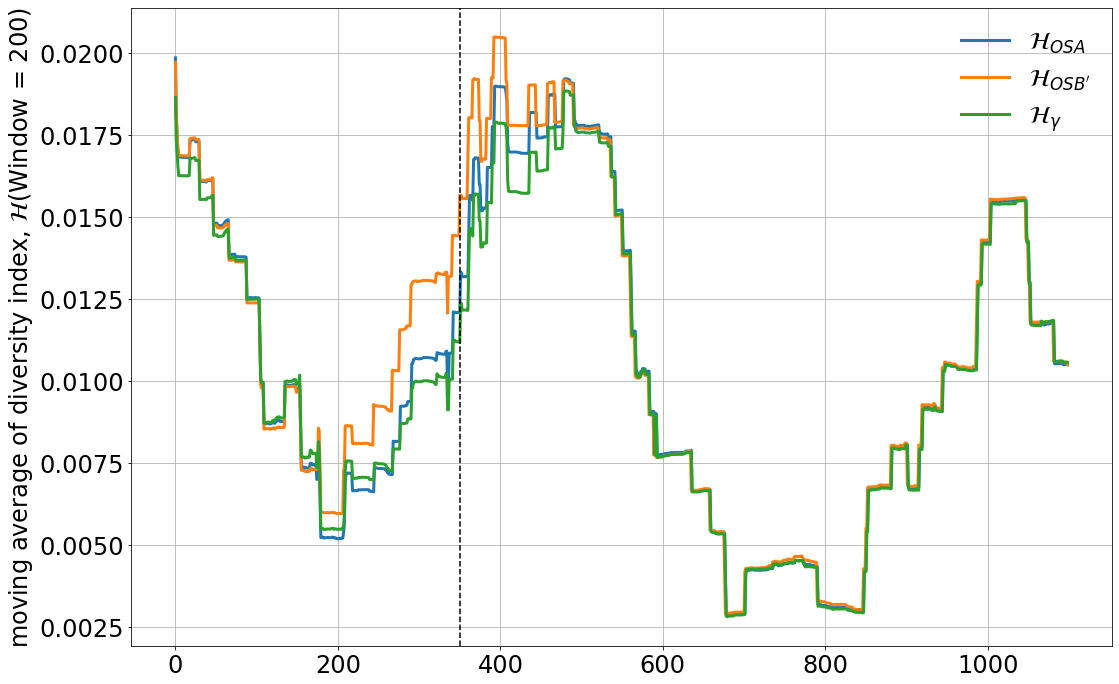

In [33]:
plt.rcParams.update(rcParams)
outpath = '/Users/harihara/Research-Activities/Plots/Hot_Spring_Plots/Single_Cell_Analyses/'

fig, ax = plt.subplots(1,1, figsize = (16,10), sharex = True, sharey = True)

ax.plot(out_mat[10]['Alpha'].tolist(), color = 'C0', linewidth = 3, label = r'$\mathcal{H}_{OSA}$')
ax.plot(out_mat[10]['Beta'].tolist(), color = 'C1', linewidth = 3, label = r'$\mathcal{H}_{OSB^\prime}$')
ax.plot(out_mat[10]['Gamma'].tolist(), color = 'C2', linewidth = 3, label = r'$\mathcal{H}_\gamma$')
ax.axvline(350, color = 'black', linestyle = '--')
ax.legend(frameon = False)
ax.set_ylabel(r'moving average of diversity index, $\mathcal{H}$(Window = 200)')
ax.grid()
fig.savefig(outpath+'Diversity-Index.pdf')
fig.tight_layout()